# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
push!(LOAD_PATH,".")
using PyPlot, HDF5
using Statistics

In [2]:
using SacaDatos
using Detectores

┌ Info: Precompiling Detectores [top-level]
└ @ Base loading.jl:1273


In [3]:
nomine = "/home/karel/ABFiles/Diana/88101619.h5"

"/home/karel/ABFiles/Diana/88101619.h5"

In [4]:
datos = h5open(nomine, "r");
names(datos)

4-element Array{String,1}:
 "ch0"        
 "channels"   
 "comment"    
 "description"

In [5]:
datos

HDF5 data file: /home/karel/ABFiles/Diana/88101619.h5

In [6]:
constantes, sweps = devuelvedatos(datos, "ch0");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5.HDF5Compound{3}((0.1, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 10.0 kHz.


In [7]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const postG=round(Int, postGms*freq)

400

In [8]:
preG

100

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [9]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [10]:
suaves=Dict{String, Array}()
derivadas=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    #aqui esta mal la escala de frecuencias, NO DEJAR DE ESPECIFICAR LA FREQ DE MUESTREO
    suaves[subs]=suavegauss(sweps[subs])
    derivadas[subs]=derivadadt(suaves[subs],freq)
end

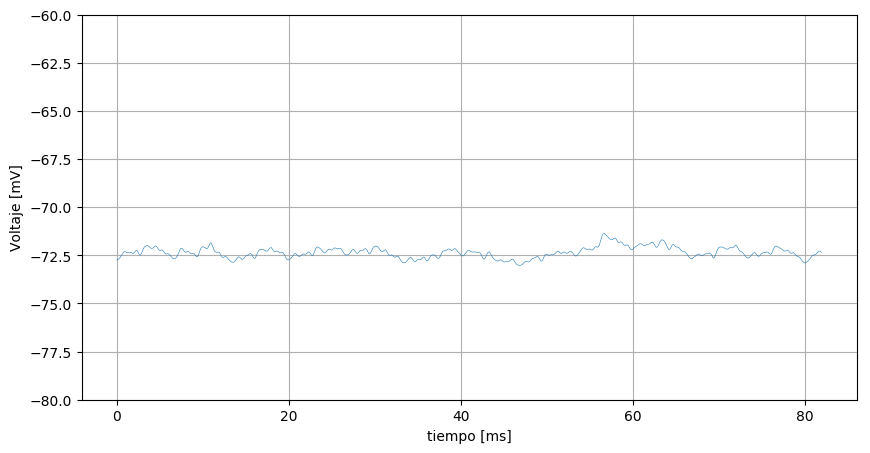

In [11]:
figura=figure(figsize=(10,5))
ylim(-80,-60)

#for subs in keys(suaves)
subs="section_36"

    lala=length(suaves[subs])
rangot=iart(1, lala)  
 plot(rangot,suaves[subs], label=subs, lw=0.4)
#end

xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
#legend()
grid()

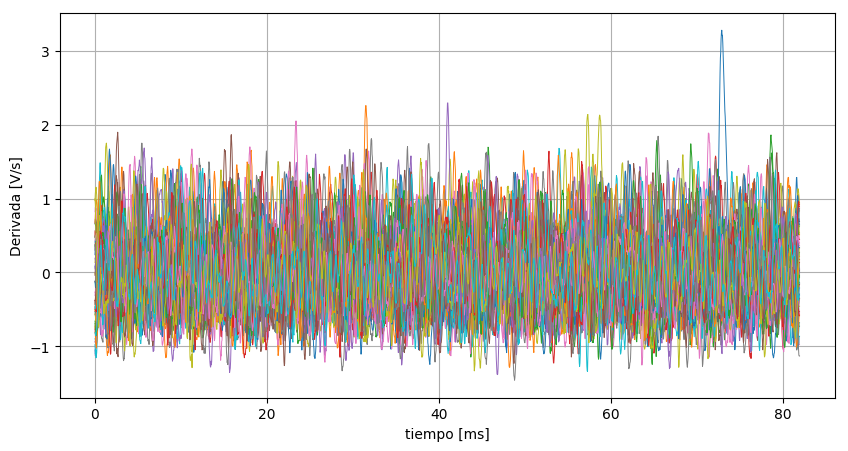

In [12]:
figura=figure(figsize=(10,5))
#ylim(-0.02, 0.5)
for subs in keys(derivadas)
lala=length(derivadas[subs])
rangot=iart(1, lala)    
 plot(rangot,derivadas[subs], label=subs, lw=0.7)
end
xlabel("tiempo [ms]")
ylabel("Derivada [V/s]")
#legend()
grid()


In [28]:
 function intervalosPP(dtrazo::Array; preG=100, postG=400,
                     uinf=0.06*deffreq, usup=0.5*deffreq)
    # recuerdese: dtrazo es la DERIVADA del trazo suavizado, no el trazo.
    #se recomienda usar una diferencia suavizada en dtrazo

    esunbrinco(x)=  x>uinf 
    escontiguo(x,y)=(y-x)==1

    result=Dict{Int, Any}()
    preresult=Dict{Int, Array}()
    
    #=
    Este primer loop encuentra los intervalos
    de INDICES contiguos que cumplen estar
    por encima del umbral
    =#
    r=findall(esunbrinco,dtrazo)
    
    if !(isempty(r))
        k=1
        preresult[1]=[]
        for j=1:length(r)-1   
            if escontiguo(r[j], r[j+1])
                push!(preresult[k], r[j+1])
            else
                k+=1
                preresult[k]=[]
            end
         end 
    
        n=length(keys(preresult))
        
    else 
        println("no hay naaaaaada en la seccion")
    end
    
    tamanointervalo=length(dtrazo)
   
    #=
    A partir del diccionario obtenido en el loop anterior:
    1) Buscamos el maximo
    2) Vemos si su valor esta debajo del segundo umbral
    3) si si, procedemos a localizar su posicion en la lista ORIGINAL de datos
    4) devolvemos una lista con todos los numeritos en ese rango de 200 antes a 800 despues
    =#
    n=length(keys(preresult))

    #println(preresult)
    
    if n>0    
        for j in keys(preresult)
            aux=preresult[j]
           # println(j," ", aux)   
            
            if aux !=[]
                (a, lugarlista) =findmax(dtrazo[aux[1]:aux[end]])
             #   println(j," ", aux)
                if a<usup
                    lugarreal=aux[lugarlista]
                    ai=lugarreal-preG
                    af=lugarreal+postG
                    (ai<1) ? ai=1 : ai=ai
                    (af>tamanointervalo) ? af=tamanointervalo : af=af
                    (maximototal, b)=findmax(dtrazo[ai:af])  
                    println("vamos bien, ", ai, " ", af, " ", maximototal)
         
                #if maximototal<40
                    result[j]=ai:af
                #end
                
                end # Este cierra el a<usup
        
            end      # cierra si aux != []  
        end # cierra j in keys 
    
    else
       # println(" te dije que no hay naaaada")
    end
    
    return result
end


intervalosPP (generic function with 1 method)

In [29]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(derivadas)
    println(subs)
 intSS[subs]=intervalosPP(derivadas[subs], preG=preG, postG=postG, uinf=0.06*freq, usup=0.4*freq)
end

section_44
vamos bien, 1344 1844 1.2678300518100372
vamos bien, 70 570 1.3268920497161218
vamos bien, 880 1380 1.0620864105135297
vamos bien, 1540 2040 1.2863296291385495
vamos bien, 494 994 0.9506565305578363
vamos bien, 1660 2048 1.2863296291385495
vamos bien, 773 1273 1.0620864105135297
vamos bien, 1773 2048 1.2863296291385495
vamos bien, 1439 1939 1.2678300518100372
vamos bien, 605 1105 1.0056123056603639
vamos bien, 1547 2047 1.2863296291385495
vamos bien, 439 939 1.2366540517518843
vamos bien, 272 772 1.2366540517518843
vamos bien, 104 604 1.3268920497161218
vamos bien, 380 880 1.2366540517518843
vamos bien, 1537 2037 1.2678300518100372
vamos bien, 1605 2048 1.2863296291385495
vamos bien, 1034 1534 1.0620864105135297
vamos bien, 1106 1606 1.1801874236240906
vamos bien, 1940 2048 1.2863296291385495
vamos bien, 1272 1772 1.2678300518100372
vamos bien, 938 1438 1.0620864105135297
vamos bien, 1 438 1.3268920497161218
section_06
vamos bien, 1241 1741 1.1971387490714136
vamos bien, 192

vamos bien, 482 982 1.2364497971091737
vamos bien, 756 1256 1.250225907567426
vamos bien, 814 1314 1.250225907567426
vamos bien, 1315 1815 1.3134810680178077
vamos bien, 648 1148 1.0944509619442044
vamos bien, 1756 2048 0.9772711558028391
vamos bien, 423 923 1.2364497971091737
vamos bien, 1924 2048 0.6957109183272081
vamos bien, 148 648 1.2364497971091737
vamos bien, 315 815 1.2364497971091737
vamos bien, 1589 2048 0.9772711558028391
vamos bien, 1816 2048 0.9772711558028391
vamos bien, 1035 1535 1.3134810680178077
vamos bien, 1148 1648 1.3134810680178077
vamos bien, 1252 1752 1.3134810680178077
vamos bien, 981 1481 1.3134810680178077
vamos bien, 1 481 1.086997343033147
section_39
vamos bien, 1925 2048 1.4611949697485471
vamos bien, 93 593 1.6550698405495723
vamos bien, 1689 2048 1.4611949697485471
vamos bien, 854 1354 1.3868086128262291
vamos bien, 427 927 2.260554268786663
vamos bien, 666 1166 2.260554268786663
vamos bien, 688 1188 2.260554268786663
vamos bien, 1854 2048 1.46119496974

vamos bien, 353 853 1.3513911827143232
vamos bien, 1462 1962 1.4047212079102422
vamos bien, 1623 2048 1.4047212079102422
vamos bien, 815 1315 1.4112340541561963
vamos bien, 853 1353 1.4112340541561963
vamos bien, 1019 1519 1.3098338983702718
vamos bien, 687 1187 1.4112340541561963
vamos bien, 1 406 1.3073254408226376
section_46
vamos bien, 1251 1751 1.1403534172760743
vamos bien, 1 479 1.5372242886979137
vamos bien, 980 1480 1.6476167962576227
vamos bien, 585 1085 1.2980991686919907
vamos bien, 1479 1979 1.2161979919962818
vamos bien, 421 921 1.2314288749493585
vamos bien, 479 979 1.2314288749493585
vamos bien, 1921 2048 1.15937909949686
vamos bien, 574 1074 1.2314288749493585
vamos bien, 1276 1776 1.1403534172760743
vamos bien, 1146 1646 1.6476167962576227
vamos bien, 442 942 1.2314288749493585
vamos bien, 1650 2048 1.2161979919962818
vamos bien, 313 813 1.4577466467631695
vamos bien, 1813 2048 1.2161979919962818
vamos bien, 89 589 1.5372242886979137
vamos bien, 18 518 1.5372242886979

vamos bien, 582 1082 1.4382768111353528
vamos bien, 1581 2048 1.2876941246293683
vamos bien, 415 915 1.4382768111353528
vamos bien, 1748 2048 1.2876941246293683
vamos bien, 186 686 1.4382768111353528
vamos bien, 248 748 1.4382768111353528
vamos bien, 1416 1916 1.2335388346151888
vamos bien, 1690 2048 1.2876941246293683
vamos bien, 1023 1523 1.5849375452923198
vamos bien, 1081 1581 1.5849375452923198
vamos bien, 1247 1747 1.5849375452923198
vamos bien, 915 1415 1.5849375452923198
vamos bien, 1 414 1.3685494379551244
section_18
vamos bien, 34 534 1.4336031227653478
vamos bien, 1866 2048 1.6182740689902886
vamos bien, 1368 1868 1.785681103046599
vamos bien, 867 1367 1.1237990390306152
vamos bien, 1201 1701 1.785681103046599
vamos bien, 1035 1535 1.2250312732192015
vamos bien, 700 1200 1.1237990390306152
vamos bien, 368 868 1.4114870746869457
vamos bien, 202 702 1.4114870746869457
vamos bien, 534 1034 1.4114870746869457
vamos bien, 1642 2048 1.6182740689902886
vamos bien, 1701 2048 1.61827

vamos bien, 948 1448 1.2138918546074962
vamos bien, 758 1258 1.2138918546074962
vamos bien, 1153 1653 1.1137739981258221
vamos bien, 597 1097 1.2138918546074962
vamos bien, 1597 2048 1.14060811837291
vamos bien, 654 1154 1.2138918546074962
vamos bien, 1651 2048 1.14060811837291
vamos bien, 1042 1542 1.2138918546074962
vamos bien, 967 1467 1.2138918546074962
vamos bien, 487 987 1.1561389784688458
vamos bien, 1225 1725 1.1137739981258221
vamos bien, 321 821 1.1561389784688458
vamos bien, 1486 1986 1.14060811837291
vamos bien, 154 654 1.1561389784688458
vamos bien, 1759 2048 0.930181257205831
vamos bien, 265 765 1.1561389784688458
vamos bien, 1096 1596 1.1137739981258221
vamos bien, 1259 1759 1.14060811837291
vamos bien, 797 1297 1.2138918546074962
vamos bien, 1729 2048 1.14060811837291
vamos bien, 819 1319 1.2138918546074962
vamos bien, 786 1286 1.2138918546074962
vamos bien, 1 467 0.9382134988587865
section_28
vamos bien, 1201 1701 1.5014751587528963
vamos bien, 147 647 1.17051655082427

In [27]:
intSS["section_44"]

Dict{Int64,Any} with 23 entries:
  1  => 1:438
  2  => 70:570
  11 => 880:1380
  21 => 1540:2040
  7  => 494:994
  26 => 1773:2048
  25 => 1660:2048
  10 => 773:1273
  19 => 1439:1939
  8  => 605:1105
  22 => 1547:2047
  6  => 439:939
  4  => 272:772
  3  => 104:604
  5  => 380:880
  20 => 1537:2037
  23 => 1605:2048
  13 => 1034:1534
  14 => 1106:1606
  27 => 1940:2048
  15 => 1272:1772
  12 => 938:1438
  18 => 1344:1844

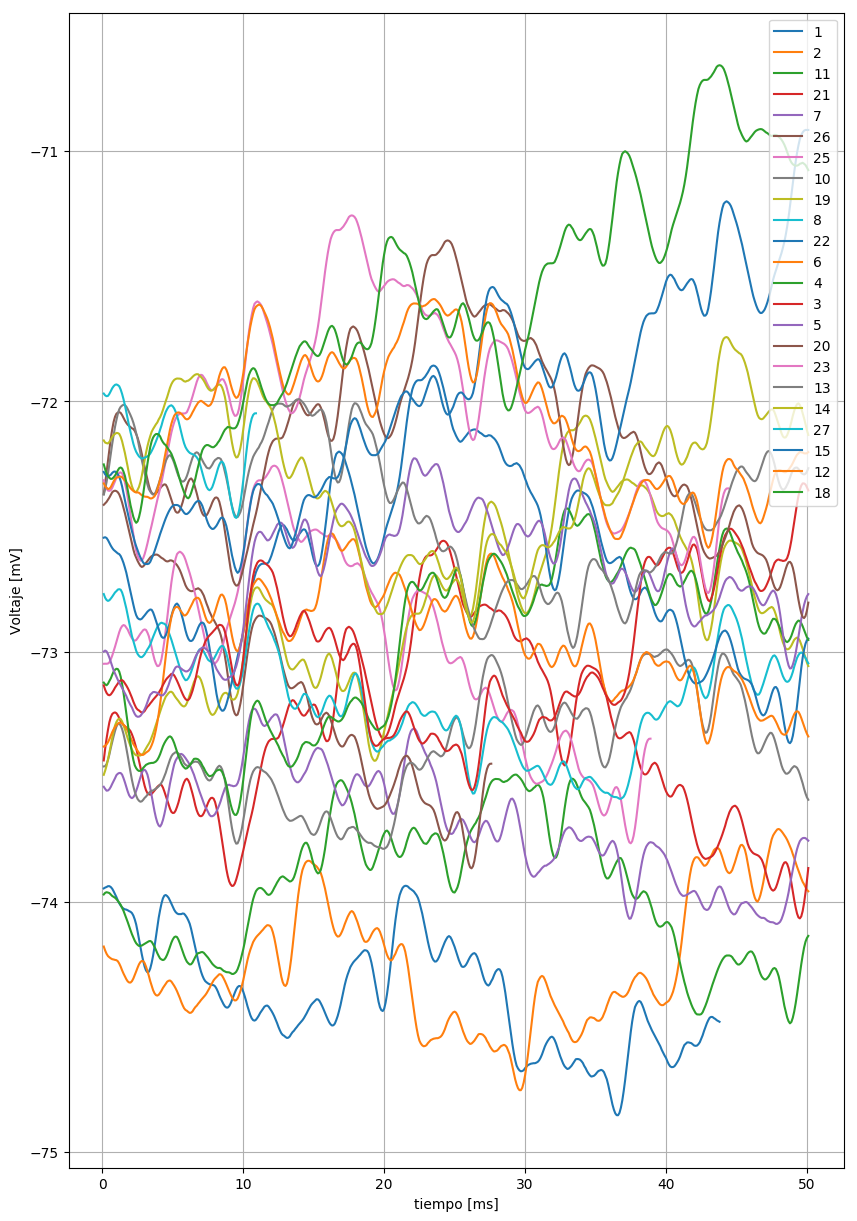

In [48]:
figura=figure(figsize=(10,15))

# Primero buscamos la lista de los intervalos ejemplo
#for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    subs="section_44"
    a=0
    for j in keys(intSS[subs])
        a=a+1
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll, freq=freq)
        plot(rangot,suaves[subs][rango].+0.1*a, label=j)
    end
#end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
legend()
grid()

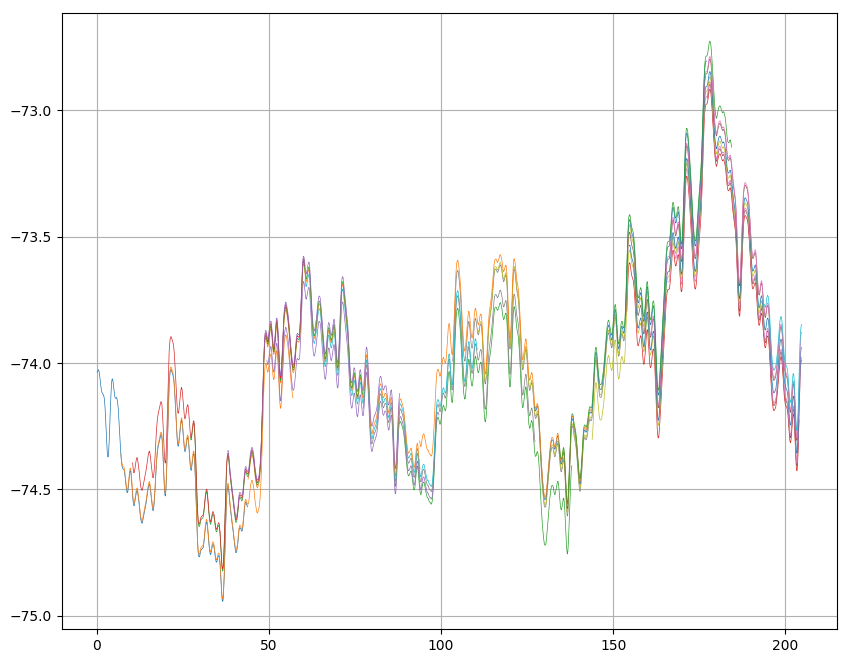

In [67]:
figura=figure(figsize=(10,8))


brango=1:length(suaves["section_44"])
brango=brango./freq
#plot(brango,suaves["section_44"], lw=0.4)

a=0
  for j in keys(intSS[subs])
        a=a+1
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
    rangot=iart(rango[1],rango[end], freq=freq)
        plot(rangot,suaves[subs][rango].+0.01*a, label=j, lw=0.5)
    end
grid()

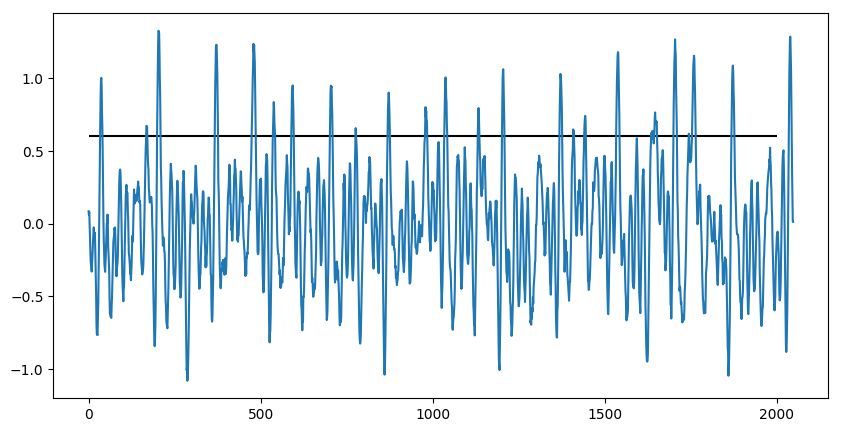

PyObject <matplotlib.collections.LineCollection object at 0x7f04cf68e630>

In [66]:
figura=figure(figsize=(10,5))
#xlim(13000,14000)
#ylim(-0.02,0.1)
  #rango=intSS[subs][1]
plot(derivadas["section_44"])
hlines([0.6], xmin=0, xmax=2000)
#plot(suaves["section_50"])

In [ ]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,derivadas[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
legend()

In [ ]:
(limpia, mocha)=separamochas(intSS);

In [ ]:
ddt=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    ddt[subs]=derivadadt(derivadas[subs])    
end

In [ ]:
figura=figure(figsize=(10,5))

title("Segundas Derivadas")

xlim(5,15)
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,ddt[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
#legend()

In [ ]:
promSpk=average1(limpia, suaves); # de ahora en adelante asi se sacan promedios sobre intervalos!


In [ ]:
function normCut(datossuave, intervaloslimpios, intervalossospechos)

    a=average1(intervaloslimpios, datossuave) # de ahora en adelante asi se sacan promedios sobre intervalos!
    offset=a[1]
    result=Dict{String,Dict}()
    
   for subs in keys(intervaloslimpios)
    result[subs]=Dict{Int, Array}()
    for j in keys(intervaloslimpios[subs])
         arre=intervalossospechos[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        #normCut[subs][j]=suaves[subs][rango].-(suaves[subs][rango][1]-a[1])
        result[subs][j]=g0(datossuave[subs][rango],a[1]) # g0 es la funcion que empareja el punto de inicio
   
    end
        
    end
    return result
end

In [ ]:
normalized=normCut(suaves, limpia, intSS)

In [ ]:
derivadalimpia=Dict{String, Dict{Int64, Array}}()
for k in keys(normalized)
    derivadalimpia[k]=Dict{Int64,Array}()
    for j in keys(normalized[k])
        derivadalimpia[k][j]=derivadadt(normalized[k][j])
    end
end

In [ ]:
figura=figure(figsize=(10,5))
rangot=0
title("Espiguletas centradas en la maxima taza de cambio")
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normalized)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normalized[subs])
           rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(rangot,normalized[subs][j])
    end
end

 xlabel("ms")
grid()
#plot(a, lw=3)

**NOTA para avanzar**

En la grafica superior, la linea gruesa es el promedio. Nos interesa calcular el tiempo que le lleva levantarse desde
el cambio en la curvatura (suave a muy empinado) hasta el máximo punto de la funcion.

In [ ]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), derivadas[subs][rango], lw=0.5)
    end
end
#plot(promSpK[2:end],difProm, lw=5, c="red")

In [ ]:
difProm=derivadadt(promSpk)
ddprom=derivadadt(difProm);

In [ ]:
riset=risetime(difProm)

In [ ]:
#plot(promSpK)
figure(figsize=(12,10))
title("Comparacion datos derivada y dderivada")
ylim(-0.2,0.2)
plot(rangot,difProm)
plot(rangot,ddprom*0.05)
plot(rangot,promSpk.+70)
axvline(x=riset[1]/freq, c="black")
axvline(x=riset[2]/freq, c="black")

grid()

# Usaremos LsqFit y una funcion perrona para hacer ajuste por cachos

In [ ]:
using LsqFit

### Vamos a arreglar esto para que las xzeros no necesiten los bordes... a no se yo creo si los vamos a tener que poner de todas formas

In [ ]:
function lpp(x, xzeros, yzeros, xini, xfin) 

    
    ll=length(xzeros)+1
    
    if ll!=length(yzeros)-1
        error("tu particion no contiene tantos parametros como necesitas \n
            Te puede faltar un y o te sobra un x")
    end
    if (x<=xini || x>=xfin)
        error("x fuera del dominio")
    end
    
     # las m son las pendientes
    mzeros=zeros(ll)
    kzeros=zeros(ll)
    xaux=vcat(xini, xzeros, xfin)   
    #println(xaux)
    
    for k=1:ll
        mzeros[k]=(yzeros[k+1]-yzeros[k])/(xaux[k+1]-xaux[k])
        kzeros[k]=yzeros[k]-mzeros[k]*xaux[k]
    end
    
    y=0
    
    for k=1:ll
        if xaux[k] <= x < xaux[k+1]
     #       println(xaux[k], " ", x, " ", xaux[k+1])
         y = mzeros[k]*x+kzeros[k]
        elseif  x==xfin
                y=yzero[end]
        
        end
    end
    
    return y

end

In [ ]:
plot(rangot[280:end],difProm[280:end])
xlabel("ms")
ylabel("Derivada [mV/ms]")
axhline([0], c="black")
axvline(10, c="black")
axvline(12, c="black")
axvline(13, c="black")
title("inspiracion")
grid()


# AHORA si es en serio:

In [ ]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

In [ ]:
yyforfit=difProm[ic:end]
xxfofit=rangot[ic:end];

In [ ]:
xxfofit

In [ ]:
xzeros5=[12,13,15.5]
yzeros5=[-0.0001, -0.4,-0.25, -0.05,-0.0001];


In [ ]:
xi=xxfofit[1]
xf=xxfofit[end]
model5(x,p)=map(xr->lpp(xr, p[1:3], p[4:8], xi, xf),x)

In [ ]:
p_0_5=vcat(xzeros5,yzeros5)

In [ ]:
yys5=map(x->lpp(x, xzeros5, yzeros5,xi,xf), xxfofit[2:end-1]);

In [ ]:
fit5 = curve_fit(model5, xxfofit[2:end-1], yyforfit[2:end-1], p_0_5);

In [ ]:
pp5=fit5.param

In [ ]:
yyfit5=model5(xxfofit[2:end-1],pp5);

Vamos a sacar nuestro $r^2$


In [ ]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit5.-mean(yyforfit)).^2)
rquad5=1-ssreg/sstot

In [ ]:
xzeros4=[12,15.5]
yzeros4=[-0.001,-0.45, -0.05,-0.001]
p_0_4=vcat(xzeros4,yzeros4)
xi=xxfofit[1]
xf=xxfofit[end]
model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)

In [ ]:
fit4 = curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)

In [ ]:
typeof(fit4)

In [ ]:
pp4=fit4.param;
yyfit4=model4(xxfofit[2:end-1],pp4);

### Hasta aqui fue con el promedio:
Ahora hay que hacerlo para cada una de las diferentes derivadas.


In [ ]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

dictfits=Dict{String,Dict{Int64, Any}}()

# Primero buscamos la lista de los intervalos ejemplo
@time for k in keys(derivadalimpia)
    dictfits[k]=Dict{Int64, Any}()
    for j in keys(derivadalimpia[k])
        aux=derivadalimpia[k][j]
        #el punto donde comienza el ajuste
        ic=findfirst(x->x<0, aux[250:end])+ip
        yyforfit=aux[ic:end]
        xxfofit=rangot[ic:end];
        xi=xxfofit[1]
        xf=xxfofit[end]
        model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)
        dictfits[k][j]=curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)
    end
end


In [ ]:
for k in keys(dictfits)
    for j in keys(dictfits[k])
        aux=dictfits[k][j]
        ppp=aux.param;
        println(ppp)
        yyfit4=model4(xxfofit[2:end-1],ppp);
        plot(xxfofit[2:end-1], yyfit4)
    end
end

In [ ]:
yyfit4[1:10]

In [ ]:
yys4=map(x->lpp(x, xzeros4, yzeros4,xi,xf), xxfofit[2:end-1]);

In [ ]:
plot(rangot[278:end],difProm[278:end])
plot(xxfofit[2:end-1], yyfit5)
plot(xxfofit[2:end-1], yyfit4)


In [ ]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit4.-mean(yyforfit)).^2)
rquad4=1-ssreg/sstot

In [ ]:
paso=1/freq
tts=0:paso:50

In [ ]:
freq

In [ ]:
np=pyimport("numpy")

In [ ]:
piezas=np[:piecewise]
piezas

## A partir de aquí estamos guardando datos

In [ ]:
using DelimitedFiles

In [ ]:
datos=hcat(promSpK[2:end],difProm)

In [ ]:
writedlm("../h5files/masterspikelet.dat", datos)

In [ ]:
nota="Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  "*nomine

In [ ]:
h5open("../h5files/masterspiklet.h5", "w") do file
   write(file, "voltaje", promSpK[2:end])  # alternatively, say "@write file A"
    write(file, "derivative", difProm)  # alternatively, say "@write file A"
    write(file, "nota", nota)  # alternatively, say "@write file A"
end


In [ ]:

test = h5open("../h5files/masterspiklet.h5", "r");
names(test)

In [ ]:
#using HDF5